In [1]:
from lxml import etree
import re
import math
import numpy as np
import pandas as pd
from collections import Counter
from pprint import pprint
from time import time
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import DBSCAN
from sklearn.decomposition import TruncatedSVD, PCA, NMF
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import Pipeline
from sklearn.mixture import BayesianGaussianMixture, GaussianMixture
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans, MiniBatchKMeans
import matplotlib.patches as mpatches
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (8.0, 4.0)

In [2]:
# Code adapted from http://stackoverflow.com/a/28384887/584121
class DenseTransformer(TransformerMixin):
    
    def __init__(self, *args, **kwargs): 
        return

    def get_params(self, deep=True): 
        """ Dummy method. """
        return {'None': 'None'}
    
    def transform(self, X, y=None, **fit_params):
        return X.todense()

    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X, y, **fit_params)
        return self.transform(X)

    def fit(self, X, y=None, **fit_params):
        return self

In [56]:
class Text(BaseEstimator, TransformerMixin): 
    def __init__(self, lenMin=2000, lenMax=2000000, maxChars=8):
        self.charDict = {}
        self.lenMin = lenMin
        self.lenMax = lenMax
        self.maxChars = maxChars
        self.allLocs = []
        
    def fit(self, *_):
        return self

    def transform(self, filename): 
        self.tree = etree.parse(filename)
        # First find and remove all letters-within-letters. 
        self.nestedLetters = self.tree.findall('.//floatingText[@type="letter"]')
        for letter in self.nestedLetters: 
            #self.parseLetter(letter)
            letter.getparent().remove(letter)
        
        # Parse letters
        self.allLetters = self.tree.findall('.//div[@type="letter"]')
        for letter in self.allLetters: 
            self.parseLetter(letter)
            
        # Flatten charDict
        self.allDocs = []
        self.allLabels = []
        for char in self.charDict: 
            for letter in self.charDict[char]: 
                self.allDocs.append(letter)
                self.allLabels.append(char)
        
        #Restrict to only the ones with appropriate lengths
        self.docs = []
        self.labels = []
        self.locs = []
        self.topChars = dict(Counter(self.allLabels).most_common(self.maxChars))
        for doc, label, loc in zip(self.allDocs, self.allLabels, self.allLocs): 
            if len(doc) > self.lenMin and len(doc) < self.lenMax:
                if label in self.topChars: 
                    self.docs.append(doc)
                    self.labels.append(label)  
                    self.locs.append(loc)
    
        self.chars = list(set(self.labels))
        
        self.numericLabels = [self.chars.index(char) for char in self.labels]
        
        self.lengths = [len(doc) for doc in self.docs]
        
        return self.docs
        
    def plotLettersPerChar(self): 
        lettersPerChar = dict(Counter(self.labels).most_common(20))
        pd.Series(lettersPerChar).plot(kind='bar')
    
    def plotHist(self): 
        print('%s documents' % len(self.docs))
        pd.Series(self.lengths).hist()
        
    def parseLetter(self, letter):
#         print(letter.tag, letter.sourceline)
        if 'who' in letter.attrib: 
            attribution = letter.attrib['who']
#             print('attribution: ', attribution)
        elif len(letter.findall('.//signed[@who]'))>0:  
            signed = letter.findall('.//signed[@who]')
#             print('signed: ', signed)
            if len(signed) > 0: 
                attribution = signed[0].attrib['who']
#                 print('signed: ', attribution)
        else: 
            attribution = None
        if attribution is not None: 
            ps = letter.findall('.//p')
            text = " ".join([" ".join(p.itertext()) for p in ps])
#             print(text[:100])
            if attribution in self.charDict: 
                self.charDict[attribution].append(text)
            
            else: 
                self.charDict[attribution] = [text]
            self.allLocs.append(letter.sourceline)


In [57]:
def translateNumColors(colorList): 
    colorDict = 'rgbcymkw'
    return [colorDict[numColor] for numColor in colorList]    

def translateNumColor(color): 
    colorDict = 'rgbcmyk'
    return colorDict[color]

In [101]:
def plotLabeled(transformed, labels, wordLabels, lengths): 
    plt.scatter(transformed[:,0], transformed[:,1], 
                c=translateNumColors(labels), s=lengths, alpha=0.8)

    # Build legend
    colorLabelAssociations = list(set(list(zip(labels, wordLabels, translateNumColors(labels)))))
#     print(colorLabelAssociations)
    legends = [mpatches.Patch(color=assoc[2], label=assoc[1])
              for assoc in colorLabelAssociations]
    plt.legend(handles=legends, loc='upper right', fontsize='small')

150 documents


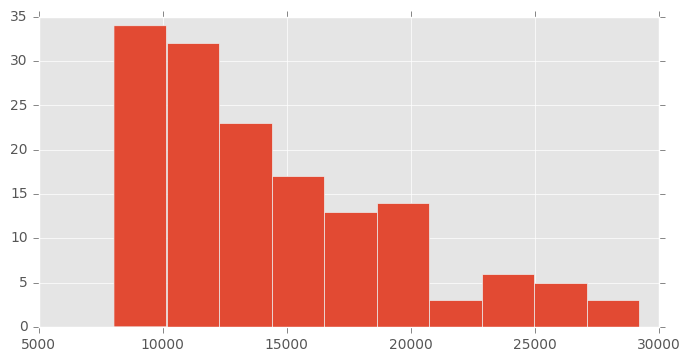

In [102]:
text = Text(lenMin=8000, lenMax=30000, maxChars=8).fit()
docs = text.transform('clarissa.xml')
labels = text.numericLabels
wordLabels = text.labels
lengths = [length/500 for length in text.lengths]
locs = [loc/500 for loc in text.locs]
text.plotHist()
# text.plotLettersPerChar()

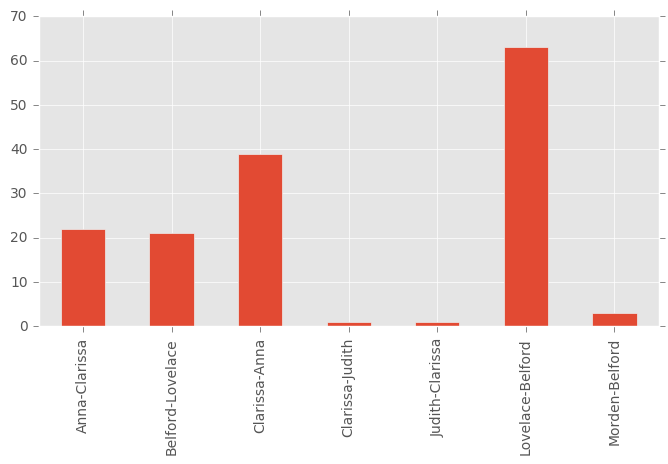

In [103]:
text.plotLettersPerChar()

In [104]:
len(text.locs)

150

In [105]:
transformPipeline = Pipeline([    
                         ('tfidf', TfidfVectorizer(max_df=0.3,
                                                  max_features=500)),
                         ('todense', DenseTransformer()),
                         ('pca', PCA(n_components=5)),
#                          ('gmm', GaussianMixture(n_components=6)),
                        ])

In [106]:
transformed = transformPipeline.fit_transform(docs)
transformed.shape

(150, 5)

In [107]:
gmm = GaussianMixture(n_components=8).fit(transformed)
bgm = BayesianGaussianMixture(n_components=8).fit(transformed)
assignments = bgm.predict(transformed)

/usr/lib/python3.5/site-packages/sklearn/mixture/base.py:237: ConvergenceWarning: Initialization 1 did not converged. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


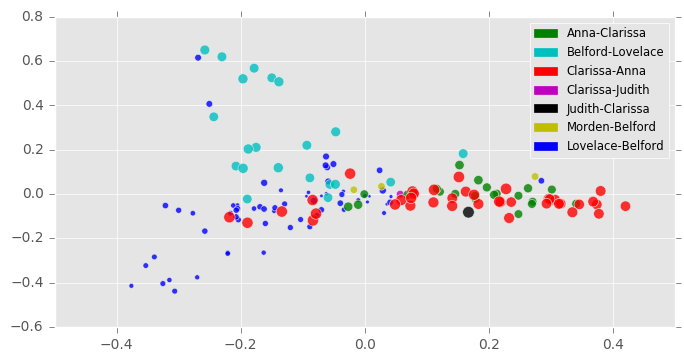

In [108]:
plotLabeled(transformed, labels, wordLabels, locs)

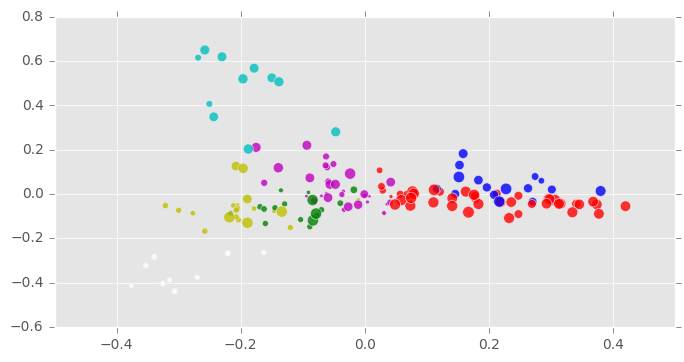

In [111]:
plt.scatter(transformed[:,0], transformed[:,1], 
            c=translateNumColors(assignments), s=locs, alpha=0.8)

In [112]:
metrics.adjusted_rand_score(assignments, labels)

0.1893462385618524

In [113]:
metrics.adjusted_mutual_info_score(assignments, labels)

0.25239238034378775